# Analysis of multiumbrella coexsitence simulations

In [106]:
import numpy as np
import matplotlib.pylab as plt
import glob, pickle
import copy                      

from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline
from matplotlib import cm
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from scipy import optimize
from matplotlib.ticker import MaxNLocator, AutoLocator
from scipy.interpolate import interp1d
import matplotlib as mpl
from scipy import integrate
import scipy
import json
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
colors_palette=['#377eb8','#4daf4a','#e41a1c','#984ea3','#ff7f00','#a65628','#f781bf','#999999']*10


%config InlineBackend.figure_format = 'retina'
!mkdir -p figures

kjtomev=0.0103642723013314*1000

### Shared settings for analysis

In [2]:
dpl=0.05 # Lower probability range for strict histogram
dph=0.05 # Upper probability range for strict histogram
dh=2     # Bin size used for histogram
NIGNORE_STANDARD=10. # percent ignore 
atm_to_gpa=0.000101325

### Plotting settings specific to the Ice-Liquid interface

In [3]:
with open('AnalysisSettings.json') as json_file:
    settings = json.load(json_file)
print(settings)

{'singlePressure': '1000.0atm', 'singleTemperature': '270.0K', 'n_temps': 5, 'n_press': 3, 'nmpi': 1, 'fig1_size': [12, 5.5], 'fig2_size': [7, 3], 'IGNORE': [], 'plotRef': [['Exp', '../../ReferenceData/exp_pd.dat', 9.86923]]}


### Load data

In [4]:
def read_colvar_dict(fn):   
    # Determine fields
    with open(fn,'r') as fp:
        top = fp.readline()
        fields= top.split()[2:]
    
    # Load data columns
    data=np.genfromtxt(fn)
    
    # Create dictionary
    ret = dict()
    for i, field in enumerate(fields):
        ret[field]=data[:,i]
    ret['time_ns']=(data[:,0]-data[0,0])/1E3 
    
    return ret

In [5]:
sims=dict()

for fold in glob.glob('COEX_*/*K/'):
    print(fold)
    sims[fold] = dict()
    try:
        colvar_files = glob.glob(fold+'COLVAR') + glob.glob(fold+'COLVAR.[0-9]')
        sims[fold]['COLVAR'] = [read_colvar_dict(fn) for fn in colvar_files]
        sims[fold]['DELTAFS'] = np.genfromtxt(fold+'DELTAFS')
        with open(fold+'DELTAFS', 'r')as fp:
            line=fp.readline()
            
        sims[fold]['DELTAFS_N_ICE'] =np.array([int(n.strip('DeltaF_')) for n in line.split()[4:]])

        sims[fold]['T'] = float(fold.split('/')[-2].strip('K'))
        sims[fold]['P'] = float(fold.split('/')[-3].replace('COEX_','').strip('atm'))
    except:
        sims.pop(fold)
        pass


COEX_1000.0atm/265.0K/
COEX_1000.0atm/270.0K/
COEX_1000.0atm/260.0K/
COEX_1000.0atm/255.0K/
COEX_2000.0atm/260.0K/
COEX_2000.0atm/240.0K/
COEX_2000.0atm/255.0K/
COEX_2000.0atm/250.0K/
COEX_2000.0atm/245.0K/
COEX_1.0atm/265.0K/
COEX_1.0atm/270.0K/
COEX_1.0atm/275.0K/
COEX_1.0atm/260.0K/
COEX_1.0atm/280.0K/


### Set number of simulations 

In [6]:
press=np.unique([k.split('/')[0] for k in sims.keys()])
n_pressures=len(press) # Number of pressures
n_temps=int(np.ceil(len(sims)/n_pressures)) # Number of temperatures simulated
n_rows=int(np.ceil(len(sims.keys())/n_temps))


## Analysis for all pressures

### Time evolution of all collective variables

In [7]:
for key in sims.keys():
    colvar=sims[key]['COLVAR'][0]
    sims[key]['NIGNORE']=int(len(colvar['time'])*NIGNORE_STANDARD/100.)
    
for ign in settings['IGNORE']:
    sims[ign[0]]['NIGNORE']=ign[1]
for key in sims.keys():
    if sum([len(sims[key]['COLVAR'][mpi]['refcv.morethan-2'])>sims[key]['NIGNORE'] for mpi in range(settings['nmpi'])])==0:
        sims[key]['NIGNORE']=-1

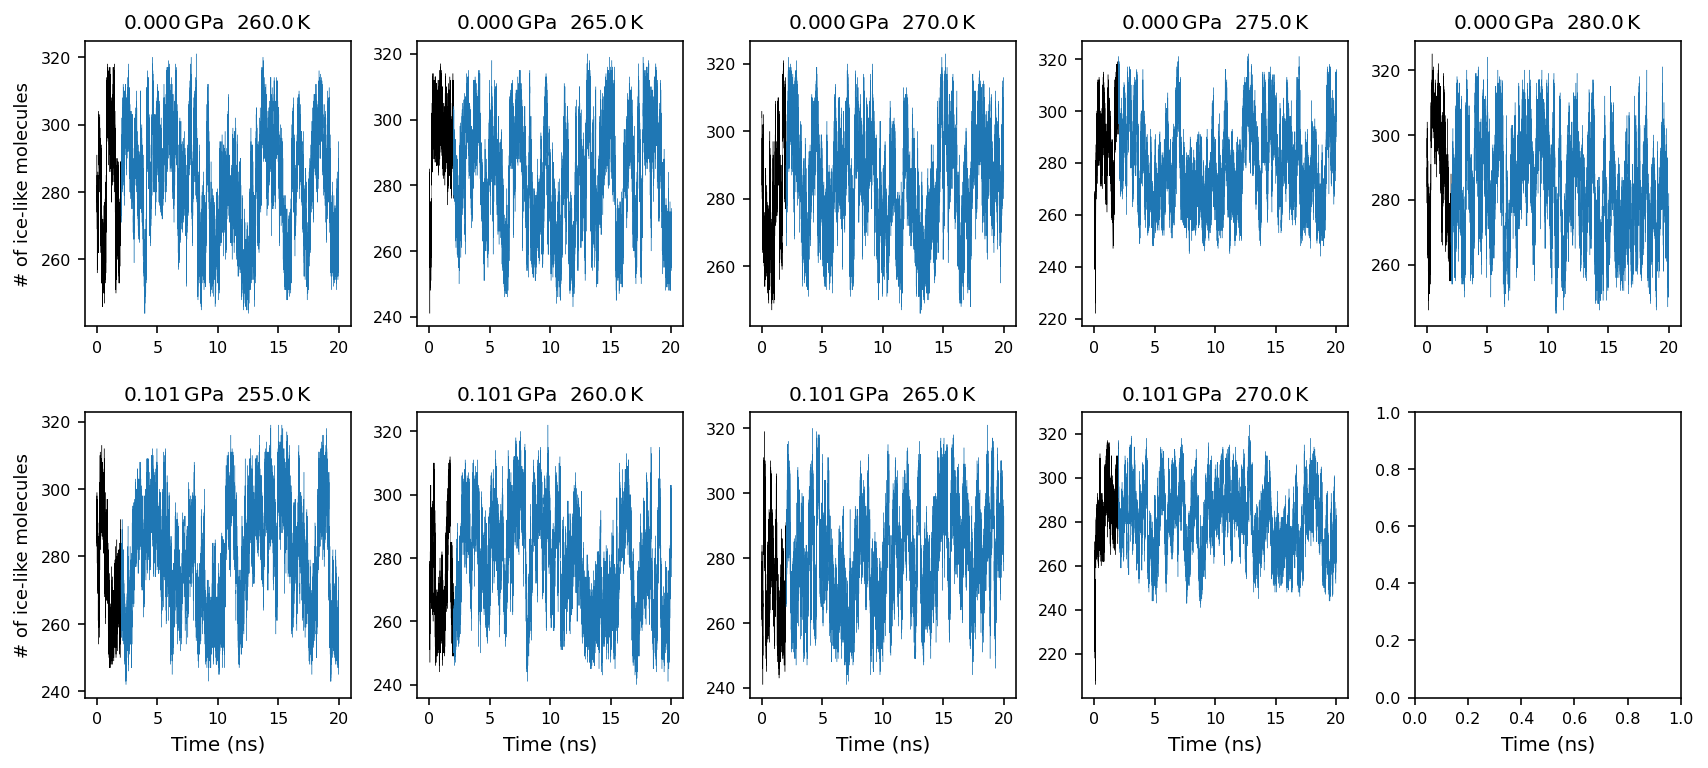

In [8]:
fig, ax = plt.subplots(n_rows,n_temps,figsize=settings['fig1_size'])
axs=ax.flatten()
i=0
for  key in sorted(sims.keys()):
    if 'COLVAR' in list(sims[key].keys()):
     
        time0=0.
        for j in range(settings['nmpi']):
            colvar=sims[key]['COLVAR'][j]
            NIGNORE=sims[key]['NIGNORE']

            
            p=float(key.replace('COEX_','').split('/')[0].strip('atm'))*atm_to_gpa
            t=key.replace('COEX_','').split('/')[1].strip('K')

            title=r'{:.3f}$\,$GPa  {}$\,$K'.format(p,t)
            axs[i].set_title(title,size = MEDIUM_SIZE)
            if sims[key]['NIGNORE']>0:
                # Part not used for fit
                axs[i].plot(time0+colvar['time_ns'][:NIGNORE],colvar['refcv.morethan-2'][:NIGNORE],'k',lw=0.2)
                # Part used for fit
                axs[i].plot(time0+colvar['time_ns'][NIGNORE:],colvar['refcv.morethan-2'][NIGNORE:],lw=0.2)
            else:
                # Whole simulation not used for fit
                axs[i].plot(time0+colvar['time_ns'],colvar['refcv.morethan-2'],'k',lw=0.2)
            time0+=colvar['time_ns'][-1]
        
        if i%n_temps==0:
            axs[i].set_ylabel('# of ice-like molecules',fontsize=9)
       
        i+=1

for j in range(n_temps):
    ax[-1,j].set_xlabel('Time (ns)')      
for j in range(i,len(sims.keys())):
    axs[j].set_visible(False)

plt.tight_layout()
plt.savefig('figures/time_evolution.png',dpi=300)

### Determine range for strict collective variable

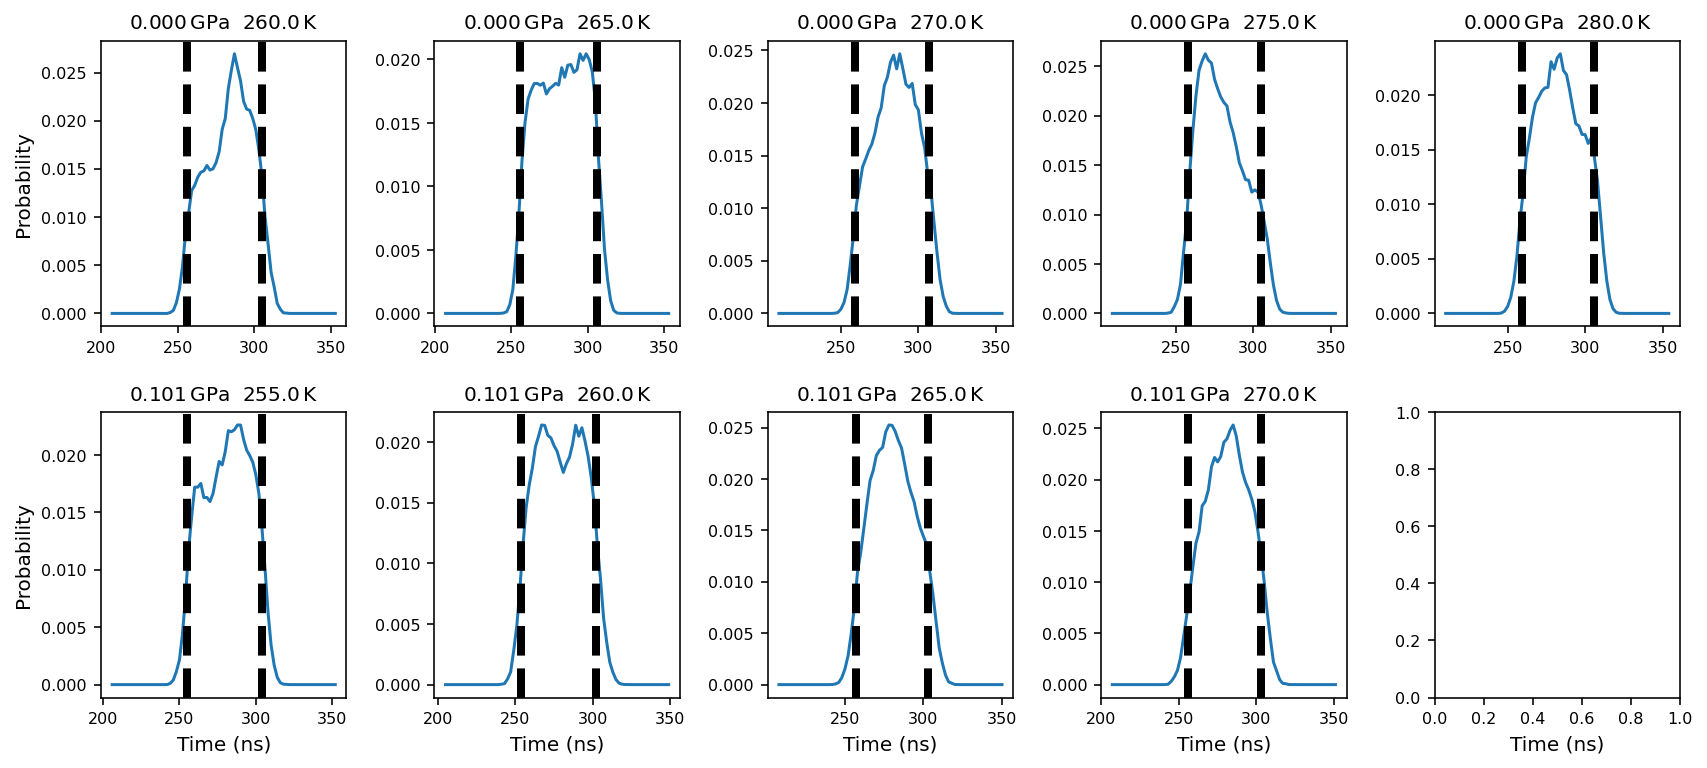

In [9]:
fig, ax = plt.subplots(n_rows,n_temps,figsize=settings['fig1_size'])
axs=ax.flatten()
for i, key in enumerate(sorted(sims.keys())):  
    NIGNORE=sims[key]['NIGNORE']
    if NIGNORE<0:
        continue
  
    number_of_ice  = np.hstack(tuple([sims[key]['COLVAR'][mpi]['refcv.morethan-2'][NIGNORE:] for mpi in range(settings['nmpi'])]))
    histo, bin_edges = np.histogram(number_of_ice,bins=1000)
    n_ice_mid=0.5*(bin_edges[1:]+bin_edges[:-1])
    
    # Determine outer range of strict collective variable histogram
    cumsum=np.cumsum(histo)
    cumsum=cumsum/cumsum.max()
    difference=np.abs(cumsum-dpl)
    ns=int(n_ice_mid[np.where(difference==difference.min())[0][0]])
    difference=np.abs(cumsum-(1-dph))
    nf=int(n_ice_mid[np.where(difference==difference.min())[0][0]])
    
    
    # Plot biased histogram
    num_ice_bins=[i for i in range(ns,nf+1)]
    bins2=[i for i in range(ns-50,nf+50)]
    sims[key]['num_ice_bins']=num_ice_bins
    histo, bin_edges = np.histogram(number_of_ice,bins=bins2[::dh],density=True)
    n_ice_mid=0.5*(bin_edges[1:]+bin_edges[:-1])
    if NIGNORE<0:
        continue
    axs[i].plot(n_ice_mid,histo)
    axs[i].axvline(x=ns,linewidth=4, color='k',ls='--')
    axs[i].axvline(x=nf,linewidth=4, color='k',ls='--')
    p=float(key.replace('COEX_','').split('/')[0].strip('atm'))*atm_to_gpa
    t=key.replace('COEX_','').split('/')[1].strip('K')

    title=r'{:.3f}$\,$GPa  {}$\,$K'.format(p,t)
    axs[i].set_title(title,size = MEDIUM_SIZE) 
    if i%n_temps==0:
        axs[i].set_ylabel('Probability')
    #i+=1

for j in range(n_temps):
    ax[-1,j].set_xlabel('Time (ns)')      
for j in range(i+1,len(sims.keys())):
    axs[j].set_visible(False)
plt.tight_layout()
plt.savefig('figures/unbiased_distributions.png',dpi=300, bbox_inches='tight')

## Compute thermodynamic potential for NN from enhanced coexistence simulations

In [96]:
def linear_fn(x, a, b):
    return a * x + b

sims_result = dict()

for i, p in enumerate(press):
    j=0
    print(p)
    for key in sims.keys():
        counter1=0

        if p in key:
            sims_result[key]=dict()

            sim=sims[key]
            colvar =sim['COLVAR']
            ignore=int(colvar[0]['opes.bias'][0]/8)

            bias = np.hstack(tuple([colvar[mpi]['opes.bias'][NIGNORE:] for mpi in range(settings['nmpi'])]))
            cv  = np.hstack(tuple([colvar[mpi]['refcv.morethan-2'][NIGNORE:] for mpi in range(settings['nmpi'])]))

            temp=sim['T']
            if (cv.shape[0]>0):
                
                # kJ/mol from PLUMED
                beta=1./(0.00831441001626*temp)
                logweights=beta*bias
                logweights -= np.amax(logweights)
                histo, bin_edges = np.histogram(cv,weights=np.exp(logweights),bins=sims[key]['num_ice_bins'])
                err = np.sqrt(np.histogram(cv,weights=np.power(np.exp(logweights),2),bins=sims[key]['num_ice_bins'])[0])
                
                bin_centers = (bin_edges[1:]+bin_edges[:-1])/2
                
                
                fes = -(1/beta)*np.log(histo)
                offset = np.mean(np.ma.masked_invalid(fes))
                fes -= offset
                feserr = (1/beta)*err/histo
                
                # Convert to meV
                fes=fes*kjtomev
                feserr=feserr*kjtomev
                
                if (fes[np.isfinite(fes)].shape[0]>0):
                    mask=np.array(np.isfinite(fes)*(feserr>0),dtype=bool)
                    popt, pcov = curve_fit(func, bin_centers[mask], fes[mask], sigma=feserr[mask])
                    perr = np.sqrt(np.diag(pcov))
                    sims_result[key]['chem_pot'] = [popt[0],perr[0]]
                    sims_result[key]['fes_linear']=linear_fn(bin_centers,*popt)  
                    sims_result[key]['fes']=fes
                    sims_result[key]['fes_err']=feserr
                    sims_result[key]['n_water']=bin_centers
                    sims_result[key]['T']=sim['T']
                    sims_result[key]['P']=float(key.split('/')[0].strip('COEX_atm'))

            counter1 += 1
            j += 1



# Correction with thermodynamic pertubation
sims_result_classical=copy.deepcopy(sims_result)

for row in np.loadtxt('pert-corr.dat'):
    key='COEX_{}atm/{}K/'.format(row[1],row[0]).replace('.0','')
    key2='COEX_{}atm/{}K/'.format(row[1],row[0])
   # print(row)
    if key in [k for k in sims_result.keys()]:
        sims_result_classical[key2]['chem_pot'][0]+=row[2]
    if key2 in [k for k in sims_result.keys()]:
        sims_result_classical[key2]['chem_pot'][0]+=row[2]
# Correction with thermodynamic pertubation and NQE 
sims_result_nqe=copy.deepcopy(sims_result)
for row in np.loadtxt('sum-corr.dat'):

    key='COEX_{}atm/{}K/'.format(row[1],row[0]).replace('.0','')
    key2='COEX_{}atm/{}K/'.format(row[1],row[0])
    if key in [k for k in sims_result.keys()]:
        sims_result_nqe[key2]['chem_pot'][0]+=row[2]
    if key2 in [k for k in sims_result.keys()]:
        sims_result_nqe[key2]['chem_pot'][0]+=row[2]



COEX_1.0atm
COEX_1000.0atm


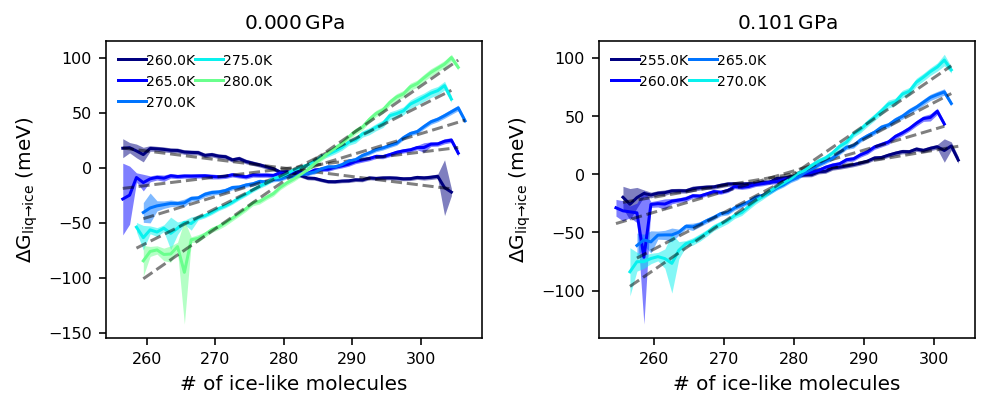

In [97]:
colors = plt.cm.jet(np.linspace(0,0.6,6))
if n_pressures>2:
    fig, axs = plt.subplots(2, int(np.ceil(n_pressures/2)),figsize=settings['fig2_size'])
    axs=axs.flatten()
elif n_pressures==2:
    fig, axs = plt.subplots(1, 2,figsize=settings['fig2_size'])
    axs=axs.flatten()
else:
    fig, axs = plt.subplots(1, 1,figsize=settings['fig2_size'])
    axs=[axs]


press=np.unique([k.split('/')[0] for k in sims_result.keys()])
for i, p in enumerate(press):
    j=0
    for key in sorted(sims_result.keys()):
        if p in key:
          
            title=r'{:.3f}$\,$GPa'.format(float(p.strip('COEX_atm'))*atm_to_gpa)
            axs[i].set_title(title,size = MEDIUM_SIZE)
            sim=sims_result[key]
            title=key.replace(p,'').strip('/')
            axs[i].fill_between(sim['n_water'],sim['fes']-3*sim['fes_err'],sim['fes']+3*sim['fes_err'],color=colors[j],linewidth=0,alpha=0.5)

            axs[i].plot(sim['n_water'],sim['fes'],color=colors[j],label=title)
            axs[i].plot(sim['n_water'],sim['fes_linear'],'--',color='black',alpha=0.5)
            j+=1
   # plot(x,linear_fn(x,*popt),'--',color='black',alpha=0.5)
    axs[i].set_xlabel(r'# of ice-like molecules')
    axs[i].set_ylabel(r'$\Delta$G$_{\mathrm{liq}\to \mathrm{ice}}$ (meV)')
    axs[i].legend(ncol=2,prop={'size': 7},handletextpad=0.0,labelspacing=0.5,columnspacing=0.0,frameon=False)
    
if len(axs)!=n_pressures:
    axs[i+1].axis('off')    
plt.tight_layout()

plt.savefig('figures/free_energies.png',dpi=300,bbox_inches='tight')

## Melting point from linear fit of chemical potential

In [112]:
approximations=['NN',r'Classical H$_2$O',r'Quantum H$_2$O']
linear_melting_points=dict()

for approx in approximations:   
    linear_melting_points[approx]=dict()

for i, p in enumerate(press):
    j=0
    
    for approx,sim_res in zip(approximations,[sims_result,sims_result_classical,sims_result_nqe]):
        chem_pot=[]
        for key in sim_res.keys():
            if p in key:

                sim=sim_res[key]
                chem_pot.append([sims[key]['T'], sim['chem_pot'][0],sim['chem_pot'][1]])
        chem_pot = np.array(chem_pot)
        try:
            popt, pcov = curve_fit(linear_fn, chem_pot[:,0], chem_pot[:,1],sigma=chem_pot[:,2])
        except:
            continue
        linear_melting_points[approx][p]=dict()    
        linear_melting_points[approx][p]['T_melt']=-popt[1]/popt[0]
        print(linear_melting_points[approx][p]['T_melt'])
        linear_melting_points[approx][p]['S_melt']=popt[0]
        linear_melting_points[approx][p]['H_melt']= -popt[1]
        linear_melting_points[approx][p]['chem_pot']=np.array(chem_pot)
        linear_melting_points[approx][p]['P']=float(p.strip('COEX_/atm'))


262.489426949318
266.22124915153904
262.3516460475754
250.34638399010657
255.01024021944488
250.37346320753315


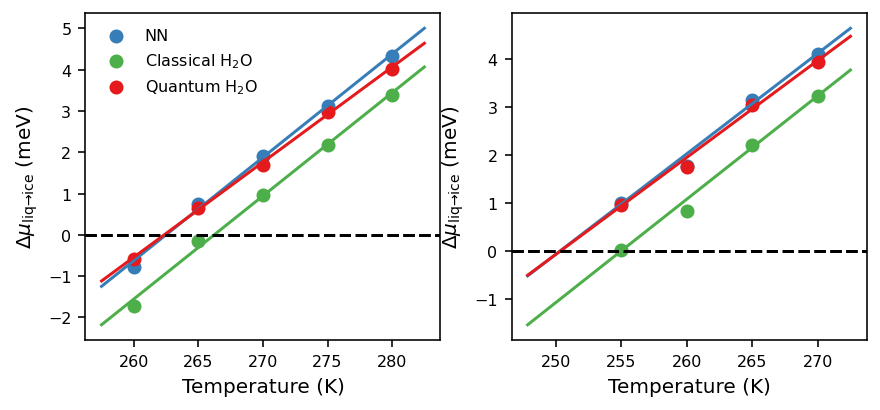

In [130]:
if n_pressures>2:
    fig, axs = plt.subplots(2, int(np.ceil(n_pressures/2)),figsize=settings['fig2_size'])
    axs=axs.flatten()
elif n_pressures==2:
    fig, axs = plt.subplots(1, 2,figsize=settings['fig2_size'])
    axs=axs.flatten()
else:
    fig, axs = plt.subplots(1, 1,figsize=settings['fig2_size'])
    axs=[axs]

coex_line=[]
chempots=dict()

for i, p in enumerate(press):
    tmin=1E6
    tmax=-1E6
    for j, approx in enumerate(linear_melting_points.keys()):
        if tmin>linear_melting_points[approx][p]['T_melt']:
            tmin=linear_melting_points[approx][p]['T_melt'] 
        if tmax<linear_melting_points[approx][p]['T_melt']:
            tmax=linear_melting_points[approx][p]['T_melt']
        if tmin>linear_melting_points[approx][p]['chem_pot'][:,0].min():
            tmin=linear_melting_points[approx][p]['chem_pot'][:,0].min() 
        if tmax<linear_melting_points[approx][p]['chem_pot'][:,0].max():
            tmax=linear_melting_points[approx][p]['chem_pot'][:,0].max()
    T=np.linspace(-2.5+tmin,tmax+2.5)
    for j, approx in enumerate(linear_melting_points.keys()):
        T_melt=linear_melting_points[approx][p]['T_melt']
        chem_pot=linear_melting_points[approx][p]['chem_pot']
        axs[i].scatter(chem_pot[:,0],chem_pot[:,1],color=colors_palette[j],label=approx)
        axs[i].plot(T,-linear_melting_points[approx][p]['H_melt']+T*linear_melting_points[approx][p]['S_melt'],color=colors_palette[j])
        axs[i].axhline(y=0.0, linestyle='--',color='k')
        axs[i].set_ylabel(r'$\Delta\mu_{\mathrm{liq}\to \mathrm{ice}}$ (meV)')
        axs[i].set_xlabel('Temperature (K)')
axs[0].legend(frameon=False)        
#     j=0
#     chem_pot=[]
#     for key in sims_result.keys():
#         if p in key:

#             sim=sims_result[key]
#             chem_pot.append([sims[key]['T'], sim['chem_pot'][0],sim['chem_pot'][1]])
#     chem_pot = np.array(chem_pot)
#     try:
#         popt, pcov = curve_fit(linear_fn, chem_pot[:,0], chem_pot[:,1],sigma=chem_pot[:,2])
#     except:
#         continue
#     axs[i].scatter(chem_pot[:,0],chem_pot[:,1])
#     #axs[i].plot(chem_pot[:,0],linear_fn(chem_pot[:,0],*popt))

#     T_melt=-popt[1]/popt[0]
#     S_melt=popt[0]
#     H_melt= -popt[1]
#     coex_line.append([float(p.strip('COEX_atm')),T_melt,H_melt,S_melt])
    
#     key='{}'.format(p)
#     chempots[str(p)]=np.vstack((chem_pot[:,0],chem_pot[:,1],linear_fn(chem_pot[:,0],*popt))).T
#     title=r'{:.3f}$\,$GPa'.format(float(p.strip('COEX_atm'))*atm_to_gpa)
#     axs[i].set_title(title,size = MEDIUM_SIZE)
#     axs[i].axhline(y=0.0, linestyle='--',color='k')
#     axs[i].axvline(x=T_melt, linestyle='--',color='k')
#     xmin,xmax = axs[i].get_xlim()
#     axs[i].set_xlim([xmin,xmax])
#     x=np.linspace(xmin,xmax,20)
#     axs[i].plot(x,linear_fn(x,*popt))
    
#     axs[i].set_ylabel(r'$\Delta\mu_{\mathrm{liq}\to \mathrm{ice}}$ (meV)')
#     axs[i].set_xlabel('Temperature (K)')
    
    
    
# coex_line=np.array(coex_line)
# coex_line=coex_line[np.argsort(coex_line[:,0])]
# np.savetxt('P_T.dat',coex_line)
# if len(axs)!=n_pressures:
#     axs[i+1].axis('off') 
# plt.tight_layout()
# plt.savefig('figures/chemical_potential.png',dpi=300, bbox_inches='tight')

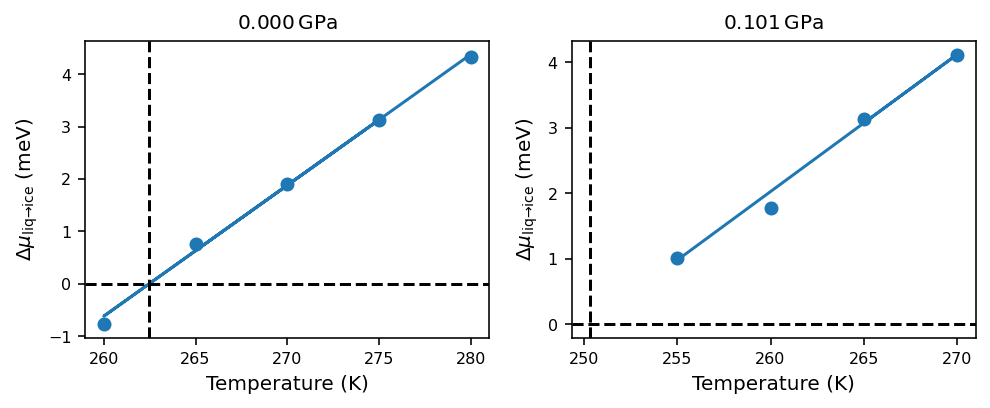

In [114]:
if n_pressures>2:
    fig, axs = plt.subplots(2, int(np.ceil(n_pressures/2)),figsize=settings['fig2_size'])
    axs=axs.flatten()
elif n_pressures==2:
    fig, axs = plt.subplots(1, 2,figsize=settings['fig2_size'])
    axs=axs.flatten()
else:
    fig, axs = plt.subplots(1, 1,figsize=settings['fig2_size'])
    axs=[axs]

coex_line=[]
chempots=dict()
for i, p in enumerate(press):
    j=0
    chem_pot=[]
    for key in sims_result.keys():
        if p in key:

            sim=sims_result[key]
            chem_pot.append([sims[key]['T'], sim['chem_pot'][0],sim['chem_pot'][1]])
    chem_pot = np.array(chem_pot)
    try:
        popt, pcov = curve_fit(linear_fn, chem_pot[:,0], chem_pot[:,1],sigma=chem_pot[:,2])
    except:
        continue
    axs[i].scatter(chem_pot[:,0],chem_pot[:,1])
    axs[i].plot(chem_pot[:,0],linear_fn(chem_pot[:,0],*popt))

    T_melt=-popt[1]/popt[0]
    S_melt=popt[0]
    H_melt= -popt[1]
    coex_line.append([float(p.strip('COEX_atm')),T_melt,H_melt,S_melt])
    
    key='{}'.format(p)
    chempots[str(p)]=np.vstack((chem_pot[:,0],chem_pot[:,1],linear_fn(chem_pot[:,0],*popt))).T
    title=r'{:.3f}$\,$GPa'.format(float(p.strip('COEX_atm'))*atm_to_gpa)
    axs[i].set_title(title,size = MEDIUM_SIZE)
    axs[i].axhline(y=0.0, linestyle='--',color='k')
    axs[i].axvline(x=T_melt, linestyle='--',color='k')
    axs[i].set_ylabel(r'$\Delta\mu_{\mathrm{liq}\to \mathrm{ice}}$ (meV)')
    axs[i].set_xlabel('Temperature (K)')
    
coex_line=np.array(coex_line)
coex_line=coex_line[np.argsort(coex_line[:,0])]
np.savetxt('P_T.dat',coex_line)
if len(axs)!=n_pressures:
    axs[i+1].axis('off') 
plt.tight_layout()
plt.savefig('figures/chemical_potential.png',dpi=300, bbox_inches='tight')

## Melting point from thermodynamic integration

In [115]:
diff_enthalphy=dict()
for fold in glob.glob('COEX_*'):
    ice=sorted(glob.glob(fold+'/Isobar/*atm/**/Ice*',recursive=True))
    liq=sorted(glob.glob(fold+'/Isobar/*atm/**/Liq*',recursive=True))
    for (i,l) in zip(ice,liq):
        p=fold 
        t=float(l.split('/')[-2].strip('K').split('_')[-2])
        enthalphy=np.loadtxt(l+'/vol_enthalpy_total.dat')[:,-1].mean()-np.loadtxt(i+'/vol_enthalpy_total.dat')[:,-1].mean()
        if p not in diff_enthalphy.keys():
            diff_enthalphy[p]=[]
        diff_enthalphy[p].append([t,enthalphy])

for key in diff_enthalphy.keys():
    diff_enthalphy[key]=np.array(diff_enthalphy[key])
    order=np.argsort(diff_enthalphy[key][:,0])
    diff_enthalphy[key]= diff_enthalphy[key][order,:]
    diff_enthalphy[key][:,1]=diff_enthalphy[key][:,1]*96.4853
    

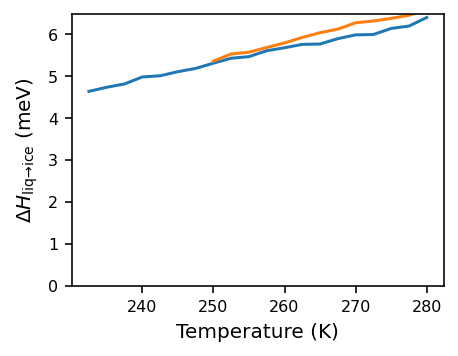

In [116]:
plt.figure(figsize=(3.33,2.5))
for key in diff_enthalphy.keys():
    T=diff_enthalphy[key][:,0]
    plt.plot(diff_enthalphy[key][:,0],diff_enthalphy[key][:,1])
    plt.ylim(bottom=0)
plt.xlabel('Temperature (K)')
plt.ylabel(r'$\Delta H_{\mathrm{liq}\to \mathrm{ice}}$ (meV)')
plt.savefig('figures/Delta_enthalpy.png',dpi=300)

In [117]:
for p in diff_enthalphy.keys():
    for key in sims_result.keys():
        if p in key:
            sims_result[key]['enthalphy_diff']=diff_enthalphy[p]


ValueError: A value in x_new is above the interpolation range.

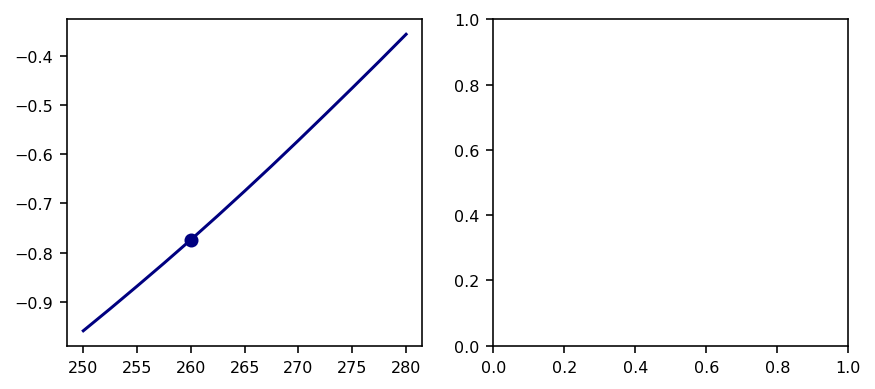

In [118]:
if n_pressures>2:
    fig, axs = plt.subplots(2, int(np.ceil(n_pressures/2)),figsize=settings['fig2_size'])
    axs=axs.flatten()
elif n_pressures==2:
    fig, axs = plt.subplots(1, 2,figsize=settings['fig2_size'])
    axs=axs.flatten()
else:
    fig, axs = plt.subplots(1, 1,figsize=settings['fig2_size'])
    axs=[axs]
PT=dict()
for p in diff_enthalphy.keys():
    PT[p]=[]

for i, p in enumerate(press):
    j=0
    for key in sorted(sims_result.keys()):
        if p in key:
            T=sims_result[key]['enthalphy_diff'][:,0]


            integrand=sims_result[key]['enthalphy_diff'][:,1]/(sims_result[key]['enthalphy_diff'][:,0]**2)
            G0=sims_result[key]['chem_pot'][0] #[[i][1]
            index=np.where(sims_result[key]['T']-T==np.abs(sims_result[key]['T']-T).min())[0][0]
            integral = T[index:]*G0/T[index]+T[index:]*integrate.cumulative_trapezoid(integrand[index:], T[index:], initial=0)
            integral2 = T[index::-1]*G0/T[index]+T[index::-1]*integrate.cumulative_trapezoid(integrand[index::-1], T[index::-1], initial=0)

            chem_pot_t=T[index::-1]*G0/T[index]+T[index::-1]*integral2

            integral_tot=np.hstack((integral2[::-1],integral[1:]))
            f2 = interp1d(T,integral_tot, kind='cubic')
            axs[i].plot(T,f2(T),color=colors[j])
            axs[i].scatter(T[index],sims_result[key]['chem_pot'][0],color=colors[j],label=str(T[index])+'K')

            j+=1
    
            
            sol = optimize.root(f2, [T[len(T)//2]], method='hybr')
            sims_result[key]['T_melt']=sol.x[0]
            title=r'{:.3f}$\,$GPa'.format(float(p.strip('COEX_atm'))*atm_to_gpa)
            axs[i].set_title(title,size = MEDIUM_SIZE)
            axs[i].axhline(y=0.0, linestyle='--',color='k')
            axs[i].set_xlabel('Temperature (K)')
            axs[i].set_ylabel(r'$\Delta\mu_{\mathrm{liq}\to \mathrm{ice}}$ (meV)')
            axs[i].legend(ncol=1,prop={'size': 7},handletextpad=0.0,labelspacing=0.5,columnspacing=0.0,frameon=False)

plt.legend()
plt.ylabel(r'$\Delta\mu_{\mathrm{liq}\to \mathrm{ice}}$ (meV)')
plt.xlabel('Temperature (K)')
if len(axs)!=n_pressures:
    axs[i+1].axis('off') 
plt.tight_layout()
plt.savefig('figures/chemical_potential_error.png',dpi=300, bbox_inches='tight')

In [ ]:
T_melts=dict()
errors=dict()
for p in press:
    T_melts[p]=[]
    errors[p]=[]
    for key in sims_result.keys():
        if p in key:
            T_melts[p].append(sims_result[key]['T_melt'])
           # print(sims_result[key]['chem_pot'])
            errors[p].append(sims_result[key]['chem_pot'][1])
PT=[]
for p in press:
    PT.append([float(p.strip('COEX_atm')),np.average(T_melts[p],weights=1/np.array(errors[p])**2)])
PT=np.array(PT)
np.savetxt('P_T_isobar.dat',PT)    

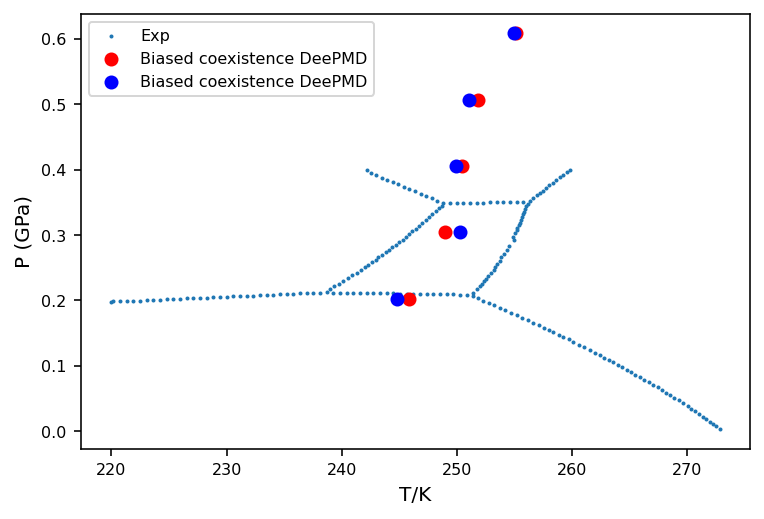

In [19]:
P_T_isobar=np.loadtxt('P_T_isobar.dat')
plt.figure()
for lines in settings['plotRef']:
    data=np.loadtxt(lines[1])
    data[:,1]*=lines[2]
    plt.scatter(data[:,0],data[:,1]*atm_to_gpa,s=1,label=lines[0])
plt.scatter(P_T_isobar[:,1],P_T_isobar[:,0]*atm_to_gpa,color='r',label='Biased coexistence DeePMD')
plt.scatter(coex_line[:,1],coex_line[:,0]*atm_to_gpa,color='b',label='Biased coexistence DeePMD')



plt.xlabel('T/K')
plt.ylabel('P (GPa)')
plt.legend()

plt.savefig('figures/phase_diagram.png',dpi=300, bbox_inches='tight')

### Store melting data

In [20]:
with open('P_T.dat','w') as fp:
    fp.write('#{:14}{:20}{:20}{:20}'.format('pressure/atm','T/K','Hfus/kJ/(mol)','Sfus/kJ/(mol K)'))
    for c in coex_line:
        fp.write('\n{:<15.0f}{:<20.1f}{:<20.1f}{:<20.5f}'.format(c[0],c[1],c[2],c[3]))
!cat P_T.dat

#pressure/atm  T/K                 Hfus/kJ/(mol)       Sfus/kJ/(mol K)     
2000           244.8               6.5                 0.02669             
3000           250.3               6.5                 0.02616             
4000           249.9               5.2                 0.02098             
5000           251.0               4.8                 0.01926             
6000           254.9               6.7                 0.02636             

### Plot of final free energy profile

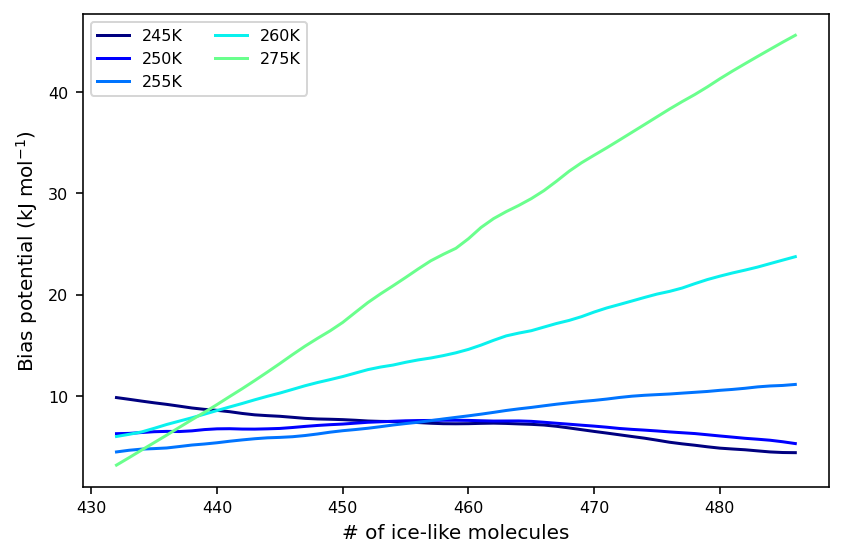

In [21]:
j=0
for i, key in enumerate(sorted(sims.keys())): 
    if settings['singlePressure'] == key.split('/')[0].strip('COEX_'):
        sim=sims[key]
        title=key.replace('COEX_'+settings['singlePressure'],'').strip('/')
        plt.plot(sims[key]['DELTAFS_N_ICE'],sim['DELTAFS'][-1,2:],color=colors[j],label=title)
        j+=1
plt.xlabel('# of ice-like molecules')
plt.ylabel(r'Bias potential (meV)')
plt.legend(ncol=2)       
plt.tight_layout()
plt.savefig('figures/bias_potentials{}.png'.format(settings['singlePressure']),dpi=300, bbox_inches='tight')

## Additional analysis

### Melting point without correction thermodynamic pertubation correction

/home/sbore/software/miniconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sbore/software/miniconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/sbore/software/miniconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


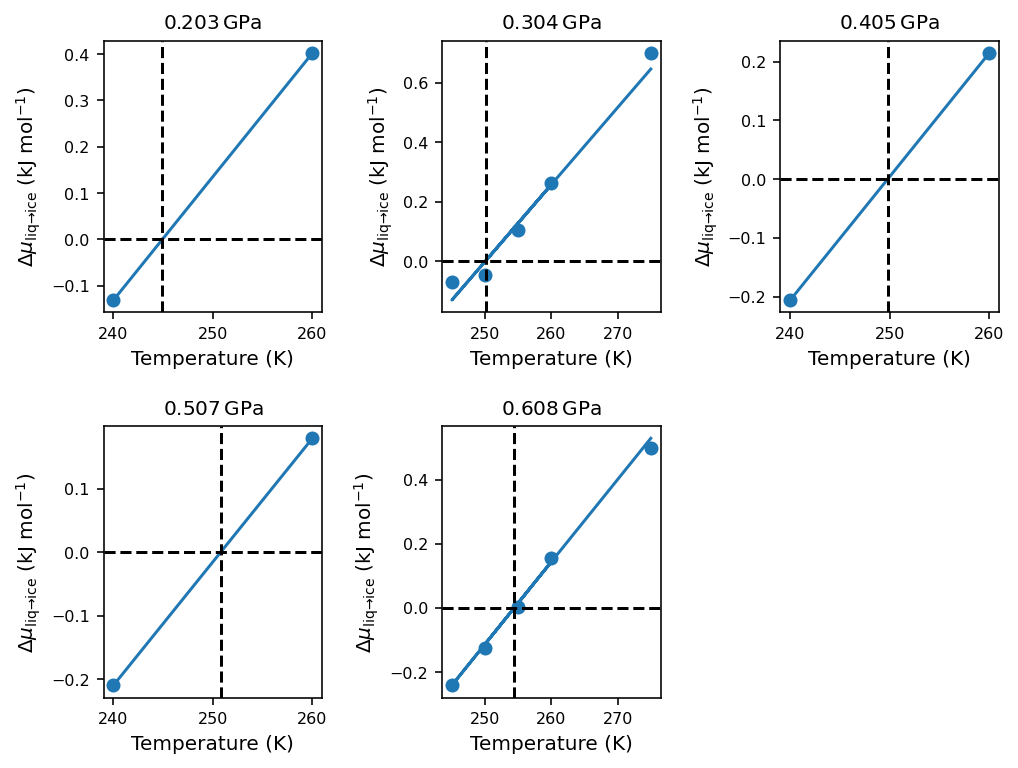

In [22]:
if n_pressures>2:
    fig, axs = plt.subplots(2, int(np.ceil(n_pressures/2)),figsize=settings['fig2_size'])
    axs=axs.flatten()
elif n_pressures==2:
    fig, axs = plt.subplots(1, 2,figsize=settings['fig2_size'])
    axs=axs.flatten()
else:
    fig, axs = plt.subplots(1, 1,figsize=settings['fig2_size'])
    axs=[axs]

coex_line_no_corr=[]
chempots=dict()
for i, p in enumerate(press):
    j=0
    chem_pot=[]
    for key in sims_result_no_corr.keys():
        if p in key:

            sim=sims_result_no_corr[key]
            chem_pot.append([sims[key]['T'], sim['chem_pot'][0],sim['chem_pot'][1]])
    chem_pot = np.array(chem_pot)
    try:
        popt, pcov = curve_fit(linear_fn, chem_pot[:,0], chem_pot[:,1],sigma=chem_pot[:,2])
    except:
        continue
    axs[i].scatter(chem_pot[:,0],chem_pot[:,1])
    axs[i].plot(chem_pot[:,0],linear_fn(chem_pot[:,0],*popt))

    T_melt=-popt[1]/popt[0]
    S_melt=popt[0]
    H_melt= -popt[1]
    coex_line_no_corr.append([float(p.strip('COEX_atm')),T_melt,H_melt,S_melt])
    
    key='{}'.format(p)
    chempots[str(p)]=np.vstack((chem_pot[:,0],chem_pot[:,1],linear_fn(chem_pot[:,0],*popt))).T
    title=r'{:.3f}$\,$GPa'.format(float(p.strip('COEX_atm'))*atm_to_gpa)
    axs[i].set_title(title,size = MEDIUM_SIZE)
    axs[i].axhline(y=0.0, linestyle='--',color='k')
    axs[i].axvline(x=T_melt, linestyle='--',color='k')
    axs[i].set_ylabel(r'$\Delta\mu_{\mathrm{liq}\to \mathrm{ice}}$ (meV)')
    axs[i].set_xlabel('Temperature (K)')
    
coex_line_no_corr=np.array(coex_line_no_corr)
coex_line_no_corr=coex_line_no_corr[np.argsort(coex_line_no_corr[:,0])]
np.savetxt('P_T_no_corr.dat',coex_line_no_corr)
if len(axs)!=n_pressures:
    axs[i+1].axis('off') 
plt.tight_layout()

plt.savefig('figures/chemical_potential_no_corr.png',dpi=300, bbox_inches='tight')

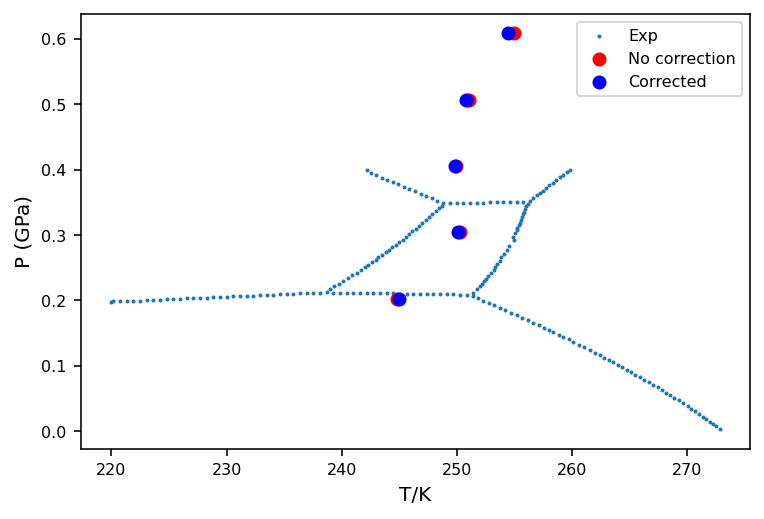

In [23]:
P_T_isobar=np.loadtxt('P_T_isobar.dat')
plt.figure()
for lines in settings['plotRef']:
    data=np.loadtxt(lines[1])
    data[:,1]*=lines[2]
    plt.scatter(data[:,0],data[:,1]*atm_to_gpa,s=1,label=lines[0])
# P_T=np.atleast_2d(np.loadtxt('P_T.dat'))
#plt.scatter(P_T_isobar[:,1],P_T_isobar[:,0]*atm_to_gpa,color='r',label='Biased coexistence DeePMD')
plt.scatter(coex_line[:,1],coex_line[:,0]*atm_to_gpa,color='r',label='No correction')
plt.scatter(coex_line_no_corr[:,1],coex_line_no_corr[:,0]*atm_to_gpa,color='b',label='Corrected')

plt.xlabel('T/K')
plt.ylabel('P (GPa)')
plt.legend()

plt.savefig('figures/phase_diagram.png',dpi=300, bbox_inches='tight')